In [1]:
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from napatrackmater.Trackvector import (TrackVector,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        
                                        )

/home/debian/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-08-05 12:50:54.921143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 12:50:54.948047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 12:50:54.956416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 12:50:54.976362: I tensorflow/core/platform/cpu_feature

In [7]:
dataset_name = 'Fifth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
save_dir = os.path.join(tracking_directory, f'cell_fate_accuracy/')
Path(save_dir).mkdir(exist_ok=True)
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))
  
goblet_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations_predicted_tracklet_length_25_t_initial_100_t_final_200/goblet_cells_{channel}annotations_inception.csv'
basal_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations_predicted_tracklet_length_25_t_initial_100_t_final_200/basal_cells_{channel}annotations_inception.csv'
radial_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations_predicted_tracklet_length_25_t_initial_100_t_final_200/radially_intercalating_cells_{channel}annotations_inception.csv'

goblet_cells_dataframe = pd.read_csv(goblet_cells_file)
basal_cells_dataframe = pd.read_csv(basal_cells_file)
radial_cells_dataframe = pd.read_csv(radial_cells_file)



gt_goblet_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations/goblet_cells_{channel}annotations.csv'
gt_basal_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations/basal_cells_{channel}annotations.csv'
gt_radial_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations/radially_intercalating_cells_{channel}annotations.csv'

gt_goblet_cells_dataframe = pd.read_csv(gt_goblet_cells_file)
gt_basal_cells_dataframe = pd.read_csv(gt_basal_cells_file)
gt_radial_cells_dataframe = pd.read_csv(gt_radial_cells_file)


In [8]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax

track_vectors._interactive_function()

Reading Master XML
Iterating over spots in frame
Iterating over tracks 901
getting attributes
returning shape and dynamic vectors as list 1332


In [9]:

tracklet_length =  10

globlet_track_ids = track_vectors._get_trackmate_ids_by_location(goblet_cells_dataframe, tracklet_length=tracklet_length)
print(f'Trackmate IDs for globlet cells {globlet_track_ids}')
basal_track_ids = track_vectors._get_trackmate_ids_by_location(basal_cells_dataframe,tracklet_length=tracklet_length)
print(f'Trackmate IDs for basal cells {basal_track_ids}')
radial_track_ids = track_vectors._get_trackmate_ids_by_location(radial_cells_dataframe,tracklet_length=tracklet_length)
print(f'Trackmate IDs for radial cells {radial_track_ids}')

gt_globlet_track_ids = track_vectors._get_trackmate_ids_by_location(gt_goblet_cells_dataframe,tracklet_length=tracklet_length)
print(f'GT Trackmate IDs for globlet cells {gt_globlet_track_ids}')
gt_basal_track_ids = track_vectors._get_trackmate_ids_by_location(gt_basal_cells_dataframe,tracklet_length=tracklet_length)
print(f'GT Trackmate IDs for basal cells {gt_basal_track_ids}')
gt_radial_track_ids = track_vectors._get_trackmate_ids_by_location(gt_radial_cells_dataframe,tracklet_length=tracklet_length)
print(f'GT Trackmate IDs for radial cells {gt_radial_track_ids}')

Trackmate IDs for globlet cells ['2248', '1168', '995', '1439', '718', '2113', '2231', '1315', '2326', '2132', '1427', '443', '291', '437', '1086', '682', '1104', '3', '479', '853', '853', '3', '2038', '2156', '1570', '1237', '2092', '1733', '739', '2257', '1680', '2304', '2355', '1961', '1735', '1348', '2343', '1099', '1945', '845', '780', '1387', '267', '1645', '1456', '903', '1749', '1386', '2313', '2054', '415', '1456', '2403', '2366', '2298', '2420', '2322', '2317', '1834', '2137', '2436', '2260', '2127', '2123', '2190', '1237', '2084']


Globlet Cells - TP: 27, FN: 88
Basal Cells - TP: 23, FN: 164
Radial Cells - TP: 11, FN: 31

Confusion Matrix:
Category   TP    FN   
Globlet    27    88   
Basal      23    164  
Radial     11    31   


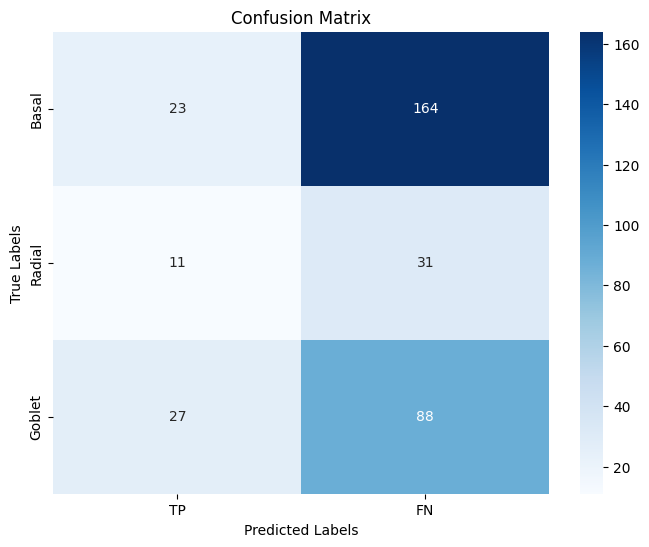

In [ ]:
class_map_gbr = {
    0: "Basal",
    1: "Radial",
    2: "Goblet"
}
def compute_tp_fn(predicted_ids, gt_ids):
    tp = len(set(predicted_ids) & set(gt_ids))
    fn = len(set(gt_ids) - set(predicted_ids))
    return tp, fn

# Compute TP and FN for each category
tp_globlet, fn_globlet = compute_tp_fn(globlet_track_ids, gt_globlet_track_ids)
tp_basal, fn_basal = compute_tp_fn(basal_track_ids, gt_basal_track_ids)
tp_radial, fn_radial = compute_tp_fn(radial_track_ids, gt_radial_track_ids)

# Print results
print(f'Globlet Cells - TP: {tp_globlet}, FN: {fn_globlet}')
print(f'Basal Cells - TP: {tp_basal}, FN: {fn_basal}')
print(f'Radial Cells - TP: {tp_radial}, FN: {fn_radial}')

# Create a confusion matrix
confusion_matrix = {
    'Category': ['Globlet', 'Basal', 'Radial'],
    'TP': [tp_globlet, tp_basal, tp_radial],
    'FN': [fn_globlet, fn_basal, fn_radial]
}

print("\nConfusion Matrix:")
print("{:<10} {:<5} {:<5}".format('Category', 'TP', 'FN'))
for i in range(len(confusion_matrix['Category'])):
    print("{:<10} {:<5} {:<5}".format(confusion_matrix['Category'][i], confusion_matrix['TP'][i], confusion_matrix['FN'][i]))


conf_matrix_array = np.array([
    [tp_basal, fn_basal],
    [tp_radial, fn_radial],
    [tp_globlet,fn_globlet]
])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = list(class_map_gbr.values())
sns.heatmap(conf_matrix_array, annot=True, fmt='d', cmap='Blues', xticklabels=['TP', 'FN'], yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()    


Globlet Cells - TP: 23.28%, FN: 75.86%
Basal Cells - TP: 11.39%, FN: 81.19%
Radial Cells - TP: 26.19%, FN: 73.81%


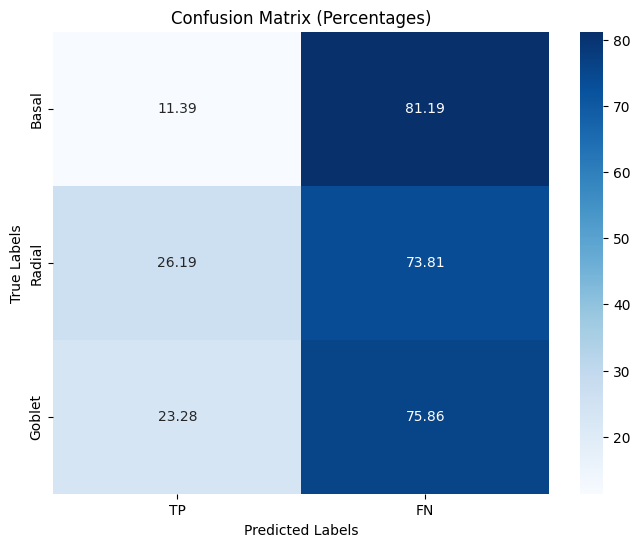

In [ ]:
# Total ground truth counts for each category
total_globlet = len(gt_globlet_track_ids)
total_basal = len(gt_basal_track_ids)
total_radial = len(gt_radial_track_ids)

# Calculate percentages
percent_tp_globlet = (tp_globlet / total_globlet) * 100 if total_globlet > 0 else 0
percent_fn_globlet = (fn_globlet / total_globlet) * 100 if total_globlet > 0 else 0

percent_tp_basal = (tp_basal / total_basal) * 100 if total_basal > 0 else 0
percent_fn_basal = (fn_basal / total_basal) * 100 if total_basal > 0 else 0

percent_tp_radial = (tp_radial / total_radial) * 100 if total_radial > 0 else 0
percent_fn_radial = (fn_radial / total_radial) * 100 if total_radial > 0 else 0

# Print results
print(f'Globlet Cells - TP: {percent_tp_globlet:.2f}%, FN: {percent_fn_globlet:.2f}%')
print(f'Basal Cells - TP: {percent_tp_basal:.2f}%, FN: {percent_fn_basal:.2f}%')
print(f'Radial Cells - TP: {percent_tp_radial:.2f}%, FN: {percent_fn_radial:.2f}%')

# Create a confusion matrix array
conf_matrix_array = np.array([
    [percent_tp_basal, percent_fn_basal],
    [percent_tp_radial, percent_fn_radial],
    [percent_tp_globlet, percent_fn_globlet]
])

save_path = Path(goblet_cells_file).parent.stem
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = list(class_map_gbr.values())
sns.heatmap(conf_matrix_array, annot=True, fmt='.2f', cmap='Blues', xticklabels=['TP', 'FN'], yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentages)')
plt.savefig(os.path.join(save_dir,save_path + '.png'))
plt.show()